In [1]:
from matplotlib import pyplot as plt
from numpy.polynomial.polynomial import polyfit
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

import numpy as np
import xgboost as xgb

In [2]:
from pathlib import Path
import pandas as pd
pd.options.mode.chained_assignment = None
import tabular_data as td

df = pd.read_csv(Path('AirbnbDataSci/tabular_data/AirBnbData.csv'))
df = td.clean_tabular_data(df)
#print(df)

features, labels = td.load_airbnb(df, "Price_Night")
#print(features)
#print(labels)

In [3]:
#scaling the data
scaler = StandardScaler()
features = scaler.fit_transform(features)
print(features)

[[-0.8058115  -0.7732395  -0.45534403 ... -2.68255683 -1.58317217
  -0.61251226]
 [-0.38490304  0.31361704 -1.66862026 ... -1.53869751 -1.93496937
  -0.61251226]
 [ 0.03600542 -0.22981123  0.15129408 ... -0.39483819  1.09048655
  -0.61251226]
 ...
 [ 0.03600542 -0.22981123  0.15129408 ...  0.17709147  0.17581383
   0.33068844]
 [ 0.87782234  0.31361704  0.7579322  ... -0.39483819 -0.80921833
   0.33068844]
 [ 0.03600542 -0.22981123 -0.45534403 ... -2.68255683 -0.45742113
   0.33068844]]


In [4]:
df.describe()

,guests,beds,bathrooms,Price_Night,Cleanliness_rate,Accuracy_rate,Communication_rate,Location_rate,Check-in_rate,Value_rate,amenities_count,bedrooms
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,3.914458,2.422892,1.375301,154.172289,4.853735,4.906024,4.933614,4.904819,4.944578,4.769036,35.501205,1.649398
std,2.377246,1.841279,0.824712,129.082913,0.182012,0.129999,0.121769,0.120717,0.103908,0.174952,14.221304,1.060859
min,1.000000,1.000000,0.000000,8.000000,3.800000,4.000000,3.900000,4.000000,3.900000,3.700000,3.000000,1.000000
25%,2.000000,1.000000,1.000000,83.250000,4.800000,4.900000,4.900000,4.900000,4.900000,4.700000,25.000000,1.000000
50%,4.000000,2.000000,1.000000,120.000000,4.900000,4.900000,5.000000,4.900000,5.000000,4.800000,35.000000,1.000000
75%,5.000000,3.000000,1.500000,176.750000,5.000000,5.000000,5.000000,5.000000,5.000000,4.900000,44.000000,2.000000
max,16.000000,17.000000,10.000000,1132.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,84.000000,10.000000


In [5]:

#define the features as generated from load_airbnb as X
X = features
#define the labels as generated from load_airbnb as y
y = labels
#split the data into test and train data; the 0.3 describes the data which is apportioned to the test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
#print(y_train)
#resplit the test data again to get a final 15 % for both test and validation
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

model = XGBRegressor(n_estimators=34,
            #decreased max_depth to decrease overfitting
            max_depth=1,
            min_child_weight=6,
            gamma=1.5,
            learning_rate=0.25,
            reg_alpha=5)
#fit the model using the training data (holding back the test and validation)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_validation_pred = model.predict(X_validation)
y_test_pred = model.predict(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

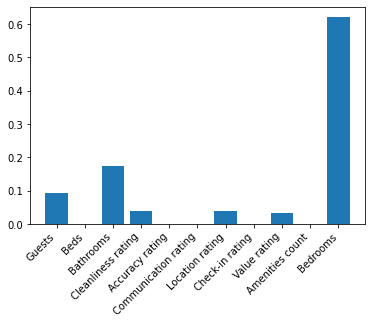

In [6]:
names = ["Guests", "Beds", "Bathrooms", "Cleanliness rating", "Accuracy rating", "Communication rating", "Location rating", "Check-in rating", "Value rating", "Amenities count", "Bedrooms"] 
importance = model.feature_importances_
plt.bar(names, importance, align="center")
plt.xticks(rotation=45, ha="right")
plt.show 

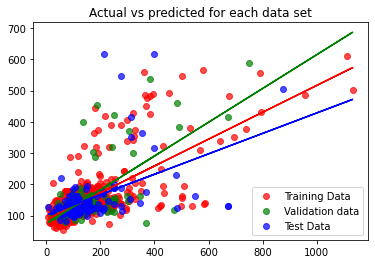

In [7]:
#plotting the actual by predicted
# polyfit to generate line of best fit
b, m = polyfit(y_train, y_train_pred, 1)
plt.plot(y_train, b + m * y_train, '-', color = 'r')

b, m = polyfit(y_validation, y_validation_pred, 1)
plt.plot(y_train, b + m * y_train, '-', color = 'g')

b, m = polyfit(y_test, y_test_pred, 1)
plt.plot(y_train, b + m * y_train, '-', color ='b')

plt.scatter(y_train, y_train_pred, label='Training Data', color = 'r', alpha=.7)
plt.scatter(y_validation, y_validation_pred, label='Validation data', color = 'g', alpha=.7)
plt.scatter(y_test, y_test_pred, label='Test Data', color = 'b', alpha=.7)
plt.legend()
plt.title("Actual vs predicted for each data set")
plt.show()

In [8]:
train_sizes, train_scores, test_scores = learning_curve(XGBRegressor(n_estimators=34,
            #decreased max_depth to decrease overfitting
            max_depth=1,
            min_child_weight=6,
            gamma=1.5,
            learning_rate=0.25,
            reg_alpha=5), X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, shuffle=True, random_state=42)



[learning_curve] Training set sizes: [ 46 150 255 359 464]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.2s finished


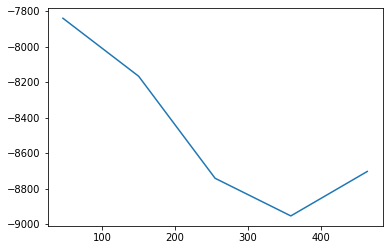

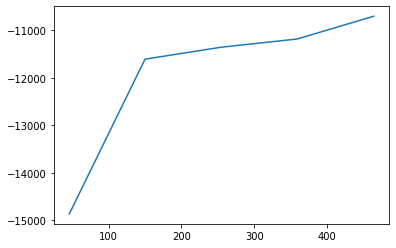

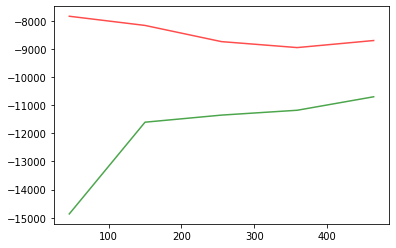

In [9]:
#take an average of all of the train cv scores at different training sizes
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)


plt.plot(train_sizes, train_mean)
plt.show()
plt.plot(train_sizes, test_mean)
plt.show()
plt.plot(train_sizes, train_mean, color='r', label='Training Data', alpha=.7)
plt.plot(train_sizes, test_mean, color='g', label='Test Data', alpha=.7)
plt.show()